# Greenberger–Horne–Zeilinger (GHZ) State Fidelity

The aim of this benchmark is to show whether a GHZ state with high enough fidelity can be prepared such that the state is genuinely multipartite entangled. One can show that a fidelity larger than 0.5 is a sufficient condition (see Leibfried, D. et al., Creation of a six-atom ‘Schrödinger cat’ state. Nature 438, 639–642 (2005))

The benchmark currently offers two methods to estimate the fidelity:
* Multiple quantum coherences (G. J. Mooney et al., Generation and verification of 27-qubit Greenberger-Horne-Zeilinger states in a superconducting quantum computer, J. Phys. Commun. 5, 095004 (2021))
* Randomized measurements (Elben, A. et al., Statistical correlations between locally randomized measurements: A toolbox for probing entanglement in many-body quantum states, Phys. Rev. A 99, 052323 (2019))

Additionally, for a given set of $n$ qubits, different circuits can be applied which lead to the same GHZ state. Currently there are the following implementations:
* "naive": The textbook ciruit of depth $n$, which starts from a Hadamrd gate on one qubit and entangles each additional qubit with a CNOT operation from the first.
* "log_depth": A logarithmic depth circuit utilizing parallel CNOT applications. Either the method in Cruz et al. https://arxiv.org/abs/1807.05572 or the method in Mooney et al. https://arxiv.org/abs/2101.08946 is used, depending on which yields the lower depth or the lower number of 2-qubit gates. 
* "tree": An in-house logarithmic depth circuit utilizing calibration data of the CZ-fidelities and a tree-graph algorithm to find a circuit with minimal depth and high fidelity 2-qubit gates. 

Note that the first two methods will always give the same circuit for the same qubit layout (and the same coupling map), while the "tree" method relies on the latest calibration fidelities and can give different circuits on different days. 
Thus for consistent comparisons one of the first two methods should be chosen, while for the best results, i.e. the largest possible GME entangled GHZ state, the tree-method is preferable.

In [1]:
from iqm.benchmarks.entanglement.ghz import *
import os
from iqm.qiskit_iqm import IQMProvider
# backend = "fakeapollo"


# token = "YOUR_TOKEN_HERE"
# os.environ["IQM_TOKEN"] = token
quantum_computer = "emerald"
iqm_server_url = "https://resonance.meetiqm.com"
provider = IQMProvider(iqm_server_url, quantum_computer = quantum_computer)
backend = provider.get_backend()

## Dynamical decoupling strategy

The success of dynamical decoupling (DD) depends on the coherence several factors, like
* Amount and lenght of idle segments in the circuit,
* Magnitude of idling errors,
* Single qubit gate fidelities (since DD adds additional single qubit gates).

Therefore just using the default DD strategy is not guaranteed to improve the results. In this notebook we apply a minimal DD strategy which only add single qubit gates on qubits with a high single qubit gate fidelity, and only adds a minimal amount of extra gates per idle segment (just tow X-Gates). This strategy should improve outcomes in most cases.

In [2]:
from iqm.iqm_client.models import DDStrategy
from iqm.benchmarks.utils import extract_fidelities_unified

# Fetch latest calibration data
_,_,_,_, metrics_dict = extract_fidelities_unified(iqm_server_url, backend, quantum_computer)

# Define DD strategy
dd_qubits = [f"QB{qubit_name+1}" for qubit_name, fidelity in metrics_dict["fidelity_1qb_gates_averaged"].items() if fidelity > 0.999]
strategy = DDStrategy(gate_sequences=[(6, 'XYYX', 'center')], target_qubits = dd_qubits)

print(f"Minimal dynamical decoupling strategy:")
for k, v in strategy.__dict__.items():
    print(f"\t{k}: {v}")

Minimal dynamical decoupling strategy:
	merge_contiguous_waits: True
	target_qubits: frozenset({'QB51', 'QB42', 'QB35', 'QB1', 'QB43', 'QB23', 'QB33', 'QB3', 'QB37', 'QB40', 'QB32', 'QB14', 'QB22', 'QB29', 'QB12', 'QB38', 'QB2', 'QB5', 'QB11', 'QB53', 'QB6', 'QB26', 'QB10', 'QB41', 'QB49', 'QB24', 'QB20', 'QB21', 'QB52', 'QB48', 'QB50', 'QB46', 'QB18', 'QB39', 'QB7', 'QB15', 'QB25', 'QB4', 'QB13', 'QB31', 'QB47', 'QB19'})
	skip_leading_wait: True
	skip_trailing_wait: True
	gate_sequences: [(6, 'XYYX', 'center')]


## Definition of the benchmark configuration
The important parameters are:
* ``custom_qubits_array``: A ``list[list[int]]`` which includes all qubit layouts on which the benchmark is run.
* ``shots``: The number of shots for the fidelity measurement
* ``fidelity_routine``: Either "coherences" or "randomized_measurements"
* ``rem``: Boolean value that controls whether readout error mitigation is used
* ``mit_shots``: Whenever rem=True, this parameter controls the total number of shots used to calibrate readout error mitgation
* ``num_RMs``: The number of randomized measurement settings (only necessary when choosing ``fidelity_routine=randomized_measurements``)

In [7]:
MINIMAL_GHZ = GHZConfiguration(
    state_generation_routine="tree",
            custom_qubits_array=[ # These are naive settings, replace with better qubit layouts!
                list(np.arange(10)),
                list(np.arange(20)),
            ],
    shots=1000,
    fidelity_routine="coherences", 
    rem=True,
    mit_shots=1000,
    use_dd = True,
    dd_strategy=strategy,
    quantum_computer=quantum_computer
)

### Improved qubit selection via layout fidelity graph

For thinking about which qubit layouts to use, the following visualization of the connectivity and CZ fidelities is helpful.

Requirements: 
* Access to the backend, in this example IQM Garnet.
* An access token environment variable needs to be set via ``os.environ["IQM_TOKEN"] = <your_token>``.

Use of the plot:
* If the ``qubit_layouts`` argument is provided, the selected qubits are marked in orange.
* CZ errors are indicated with edge width (**thinner edge is better**), where the edge width is given by $w_{ij} = - \mathrm{log}(\mathcal{F}_{\mathrm{CZ}}^{ij})$.
* Each edge is also labeled with the width value. 
* Some graph layouts are predefined to match the layout as shown in IQM-Resonance. If the layout is not predefined, a graph in grid or star layout will be automatically generated, dependeing on the backend. Automatically generated graphs might need to be rerun a few times until a nice node layout is found.
* Single qubit errors are visualized as node size (**smaller radius is better**), with the node size being determined by $- \mathrm{log}(\mathcal{F})$, where $\mathcal{F}$ is either the single qubit average gate fidelity, the single qubit readout fidelity, or the single qubit idle gate fidelity. Which of these is used can be controlled by the ``sq_metric`` argument, which can be set to "fidelity" "readout", or "coherence", where the latter option leads to the idle fidelities being shown.
* If the option `show_ghz_path` is set to True, the connections used for creating the GHZ state are highlighted red. Furthermore the "Edge map" is printed, which is the list of qubit pairs on which CZ gates act in the GHZ circuit. The list is ordered, so the first pair is scheduled first, and so on. CZ-Gates on subsequent pairs that don't share the same qubit are executed in parallel. 

Check if access token environment variable is set: True
Edge map: [[10, 11], [10, 18], [11, 5], [18, 17], [11, 12], [11, 19], [5, 4], [17, 16], [5, 6], [12, 13], [4, 3], [4, 0], [16, 15], [3, 2], [3, 9], [0, 1], [15, 14], [15, 7], [2, 8]]


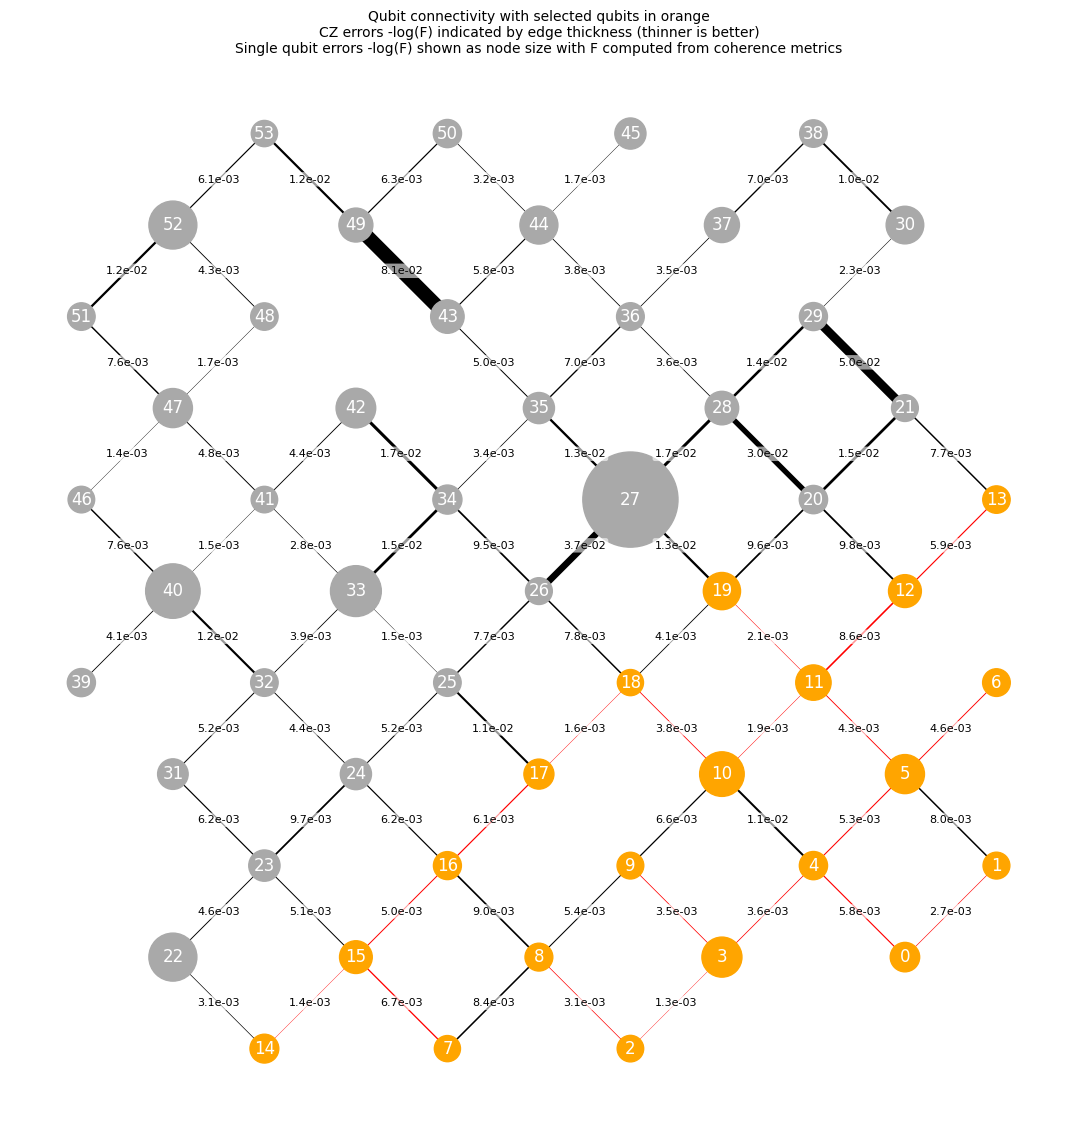

In [8]:
from iqm.benchmarks.utils_plots import plot_layout_fidelity_graph
import os

print(f"Check if access token environment variable is set: {'IQM_TOKEN' in os.environ}")
qubit_layouts = [list(range(20))]
fig = plot_layout_fidelity_graph(iqm_server_url, backend, quantum_computer = quantum_computer, qubit_layouts = qubit_layouts, sq_metric="coherence", show_ghz_path = True)

## Running the benchmark

In [9]:
benchmark_ghz = GHZBenchmark(backend, MINIMAL_GHZ)
run_ghz = benchmark_ghz.run()

2026-01-28 12:05:53,608 - iqm.benchmarks.logging_config - INFO - Now generating a 10-qubit GHZ state on qubits [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
2026-01-28 12:05:53,612 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQMBackend with optimization level 3, sabre routing method including SQG optimization all circuits
2026-01-28 12:05:56,697 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQMBackend with optimization level 3, sabre routing method including SQG optimization all circuits
2026-01-28 12:05:59,045 - iqm.benchmarks.logging_config - INFO - Submitting batch with 23 circuits corresponding to qubits [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
C:\Users\RaphaelBrieger\.local\share\mamba\envs\benchmarks_new\Lib\site-packages\iqm\qiskit_iqm\iqm_provider.py:191: UserWarning: Unknown backend option(s): {'calibration_set_id': None}
  warnings.warn(f"Unknown backend option(s): {unknown_options}")
2026-01-28 12:06:00,134 - iqm.benchmarks.logging_config - INFO - Now generati

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-28 12:06:43,940 - iqm.benchmarks.logging_config - INFO - Adding counts to dataset
2026-01-28 12:06:44,108 - iqm.benchmarks.logging_config - INFO - Retrieving all counts
2026-01-28 12:06:44,472 - iqm.iqm_server_client.iqm_server_client - INFO - Waiting for job 019c0448-381c-7ec1-8091-78f4ee536965 to finish...
2026-01-28 12:06:48,789 - iqm.benchmarks.logging_config - INFO - Adding counts to dataset
2026-01-28 12:06:49,109 - iqm.benchmarks.logging_config - INFO - Applying readout error mitigation
C:\Users\RaphaelBrieger\.local\share\mamba\envs\benchmarks_new\Lib\site-packages\iqm\qiskit_iqm\iqm_provider.py:191: UserWarning: Unknown backend option(s): {'rep_delay': None}
  warnings.warn(f"Unknown backend option(s): {unknown_options}")


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-28 12:07:24,338 - iqm.benchmarks.logging_config - INFO - Adding counts to dataset


In [10]:
result = benchmark_ghz.analyze()

## Accessing the results
To see individual fidelitiy and uncertainty values of a given qubit layout, one can filter the ``result.observations``-list by layout as shown below. 

The plot allows a comparison of all layout results with and without REM, where the data point description labels "L0", "L1", ... enumerate the layouts in the order defined in the configuration.

fidelity: 0.5166038909963064 +/- None
fidelity_rem: 0.6460375601220506 +/- None


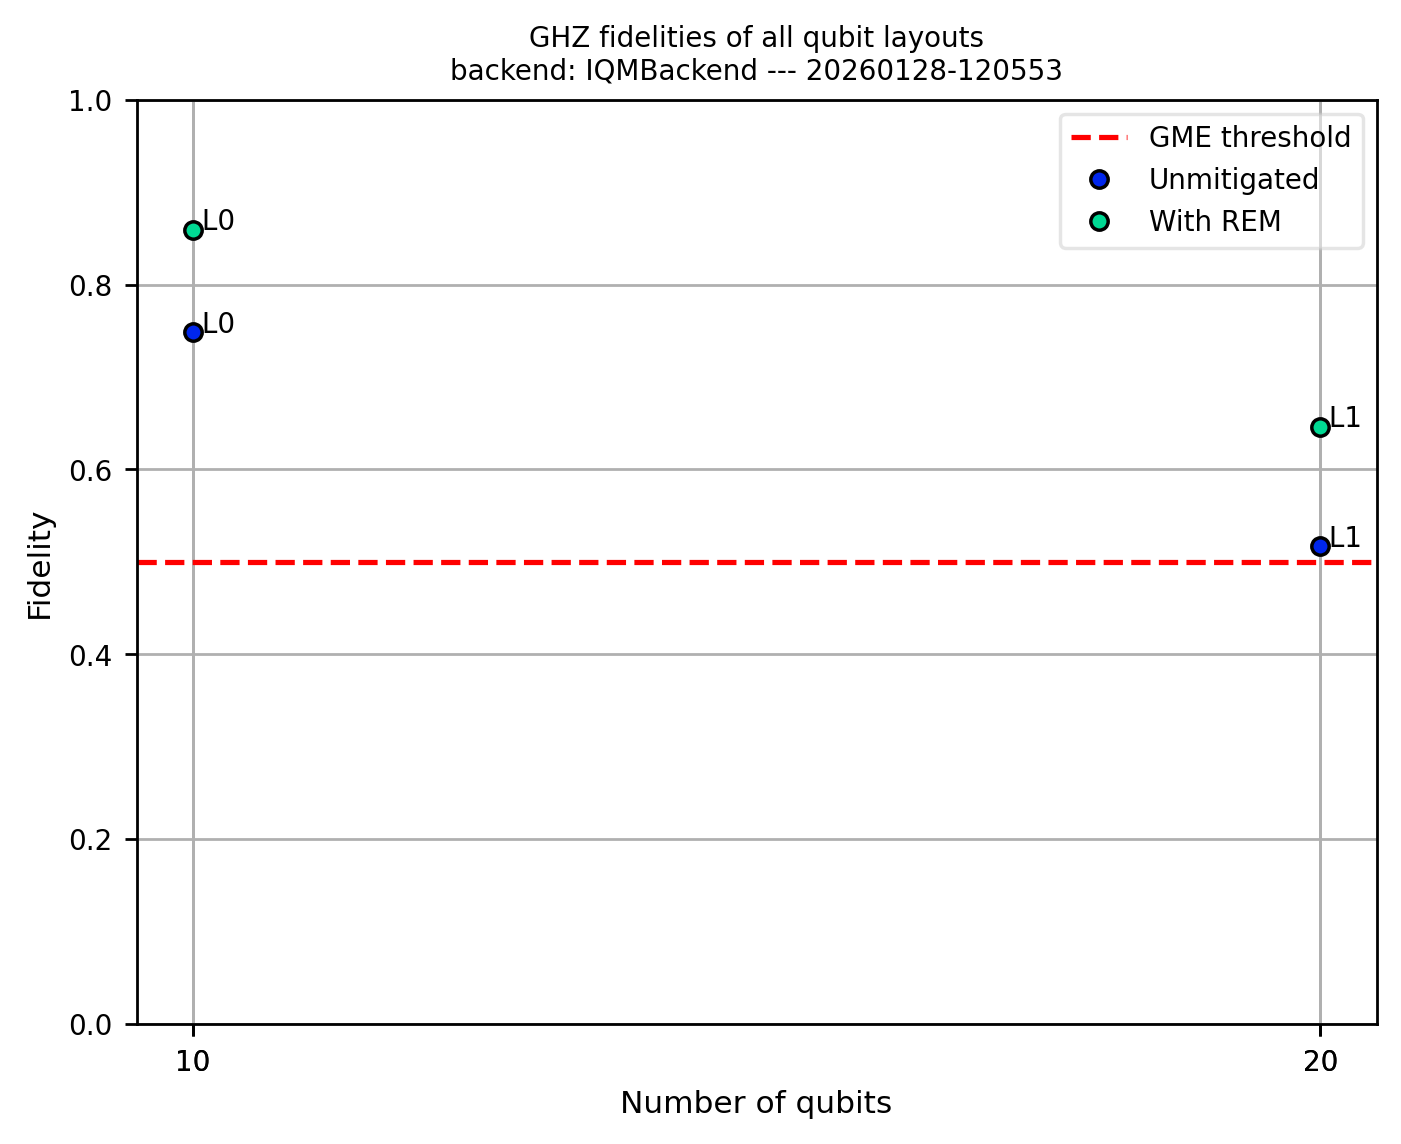

In [11]:
qubit_layout = list(range(20))
for observation in result.observations:
    if observation.identifier.string_identifier == str(qubit_layout):
        print(f"{observation.name}: {observation.value} +/- {observation.uncertainty}")
result.plot_all()